Let's start with the Feed-Forward analysis.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

import sklearn.decomposition
import matplotlib.pyplot as plt

mnist_data, mnist_info = tfds.load('mnist', with_info=True)
print(mnist_info)
mnist_train_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['train'])])
mnist_train_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['train'])])

mnist_test_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['test'])])
mnist_test_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['test'])])

First, we need to decide the number of neurons of each hidden layer. The thumb rule says that it should be between the input and output size. With this in mind, let's test and verify which brings us the best results.

In [ ]:
neurons = [100, 200, 300, 400, 500, 600, 700]
modelsResults = []
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

for i in range(len(neurons)):
  filename = 'mnist_two_layers_'+str(neurons[i])+'_best.h5'
  modelname = 'mnist_ff_two_layers_'+str(neurons[i])
  checkpoint_two_layers = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True)
  mnist_two_layers_model = tf.keras.Sequential(name=modelname)
  mnist_two_layers_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_two_layers_model.add(tf.keras.layers.Flatten(name='flatten'))
  mnist_two_layers_model.add(tf.keras.layers.Dense(neurons[i], activation='tanh', name='test'))
  mnist_two_layers_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_two_layers_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_two_layers_model.summary()

  mnist_two_layers_model_train = mnist_two_layers_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint_two_layers], epochs=10000, batch_size=256)
  mnist_two_layers_model.load_weights(filename)
  loss, acc = mnist_two_layers_model.evaluate(mnist_test_x, mnist_test_y)
  modelsResults += [[loss, acc]]

Let's plot and check the results:

In [ ]:
resultsArray = np.array(modelsResults)
resultsArray = np.array([[0.1103, 0.9678], [0.0981, 0.9709], [0.0957, 0.9706], [0.0960, 0.9715], [0.1084,0.9681], [0.1096, 0.9686], [0.1080,0.9688]])
# best result: neurons = 400
print("Best result:", neurons[np.argmax(resultsArray, axis=0)[1]])
#print(resultsArray[:,1])

accuracyMaxIndex = np.argmax(resultsArray, axis=0)[1]
lossMinIndex = np.argmin(resultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('Neurons Analysis - Loss')
loss_ax.plot(neurons, resultsArray[:,0] , '-r', label='Train')
loss_ax.plot(neurons[lossMinIndex], resultsArray[:,0][lossMinIndex], "X")
loss_ax.set_xlabel("Neurons")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('Neurons Analysis - Accuracy')
acc_ax.plot(neurons, resultsArray[:,1], '-g', label='Train')
acc_ax.plot(neurons[accuracyMaxIndex], resultsArray[:,1][accuracyMaxIndex], "X")
acc_ax.set_xlabel("Neurons")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()


The next step is to decide the number of hidden layers of our model. 
Let's test and verify which brings us the best balance of accuracy and complexity without overfitting. 

In [ ]:
# test between 2 - 7 layers
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelLayersResults = []
for i in range(2,8):
  filename = 'mnist_'+str(i)+'_layers_best.h5'
  modelname = 'mnist_ff_'+str(i)+'_layers'
  mnist_model = tf.keras.Sequential(name=modelname)
  mnist_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_model.add(tf.keras.layers.Flatten(name='flatten'))
  for j in range(i-1):
    mnist_model.add(tf.keras.layers.Dense(neurons[np.argmax(resultsArray, axis=0)[1]], activation='tanh', name='hidden_layer_'+str(j+1)))
  mnist_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_model.summary()

  mnist_model.load_weights(filename)
  loss, acc = mnist_model.evaluate(mnist_test_x, mnist_test_y)
  modelLayersResults += [[loss, acc]]

for result in modelLayersResults:
  print(result)

Let's plot and check the results.

In [ ]:
layerResultsArray = np.array(modelLayersResults)
# best result: 4 hidden layers
print("Best result:", np.argmax(layerResultsArray, axis=0)[1] + 1)

accuracyMaxIndex = np.argmax(layerResultsArray, axis=0)[1]
lossMinIndex = np.argmin(layerResultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('Hidden Layers Analysis - Loss')
loss_ax.plot(np.arange(1,7), layerResultsArray[:,0] , '-r', label='Train')
loss_ax.plot(lossMinIndex+1, layerResultsArray[:,0][lossMinIndex], "X")
loss_ax.set_xlabel("Hidden Layers")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('Hidden Layers Analysis - Accuracy')
acc_ax.plot(np.arange(1,7), layerResultsArray[:,1], '-g', label='Train')
acc_ax.plot(accuracyMaxIndex+1, layerResultsArray[:,1][accuracyMaxIndex], "X")
acc_ax.set_xlabel("Hidden Layers")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()

Now let's explore the Regularization methods. 
The regularization factor should be between 1 and the number of instances of the dataset. Let's do some testing in l1 and l2:

In [ ]:
# training dataset contains 60000 instances, so we'll vary the parameter between 1 and 600000
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelRegularizationResults = []
for i in range(0,100, 10):
  filename = 'mnist_4_layers_+'+str(i)+'best.h5'
  modelname = 'mnist_ff_4_layers_'+str(i)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True)

  mnist_model = tf.keras.Sequential(name=modelname)
  mnist_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_model.add(tf.keras.layers.Flatten(name='flatten'))

  mnist_model.add(tf.keras.layers.Dense(400, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(i/100), name='hidden_layer_0'))
  for j in range(3):
    mnist_model.add(tf.keras.layers.Dense(400, activation='tanh', name='hidden_layer_'+str(j+1)))

  mnist_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_model.summary()
  mnist_model_train = mnist_model.fit(mnist_train_x[:5000], mnist_train_y[:5000], validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_model.load_weights(filename)
  loss, acc = mnist_model.evaluate(mnist_test_x, mnist_test_y)
  modelRegularizationResults += [[loss, acc]]
  print(modelRegularizationResults)

for result in modelRegularizationResults:
  print(result)


In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelRegularizationResultsL1 = []
for i in range(0,100, 10):
  filename = 'mnist_4_layers_L1_+'+str(i)+'best.h5'
  modelname = 'mnist_ff_4_layers_L1_'+str(i)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True)

  mnist_model = tf.keras.Sequential(name=modelname)
  mnist_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_model.add(tf.keras.layers.Flatten(name='flatten'))

  mnist_model.add(tf.keras.layers.Dense(400, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1(i/100), name='hidden_layer_0'))
  for j in range(3):
    mnist_model.add(tf.keras.layers.Dense(400, activation='tanh', name='hidden_layer_'+str(j+1)))

  mnist_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_model.summary()
  mnist_model_train = mnist_model.fit(mnist_train_x[:5000], mnist_train_y[:5000], validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_model.load_weights(filename)
  loss, acc = mnist_model.evaluate(mnist_test_x, mnist_test_y)
  modelRegularizationResultsL1 += [[loss, acc]]
  print(modelRegularizationResultsL1)

for result in modelRegularizationResultsL1:
  print(result)

Let's plot and check the results:

In [ ]:
L1regularizationResultsArray = np.array(modelRegularizationResultsL1)
L2regularizationResultsArray = np.array(modelRegularizationResults)


regLimits = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# best result: 0-0.1 
print("Best result:", regLimits[np.argmax(regularizationResultsArray, axis=0)[1]])

L1accuracyMaxIndex = np.argmax(L1regularizationResultsArray, axis=0)[1]
L1lossMinIndex = np.argmin(L1regularizationResultsArray, axis=0)[0]
L2accuracyMaxIndex = np.argmax(L2regularizationResultsArray, axis=0)[1]
L2lossMinIndex = np.argmin(L2regularizationResultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('Regularization Broad Analysis - Loss')
loss_ax.plot(regLimits, L1regularizationResultsArray[:,0] , '-g', label='L1')
loss_ax.plot(regLimits, L2regularizationResultsArray[:,0] , '-b', label='L2')


loss_ax.set_xlabel("Regularization Factor")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('Regularization Broad Analysis - Accuracy')
acc_ax.plot(regLimits, L1regularizationResultsArray[:,1] , '-g', label='L1')
acc_ax.plot(regLimits, L2regularizationResultsArray[:,1] , '-b', label='L2')

acc_ax.set_xlabel("Regularization Factor")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()

Now we need to shorten the intervals in order to find the ideal value.

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelRegularizationResultsL1 = []
for i in range(0,100, 10):
  filename = 'mnist_4_layers_L1_+'+str(i/1000)+'best.h5'
  modelname = 'mnist_ff_4_layers_L1_'+str(i/1000)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True)

  mnist_model = tf.keras.Sequential(name=modelname)
  mnist_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_model.add(tf.keras.layers.Flatten(name='flatten'))
  for j in range(4):
    mnist_model.add(tf.keras.layers.Dense(400, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1(i/1000), name='hidden_layer_'+str(j+1)))
  mnist_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_model.summary()
  mnist_model_train = mnist_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_model.load_weights(filename)
  loss, acc = mnist_model.evaluate(mnist_test_x, mnist_test_y)
  modelRegularizationResultsL1 += [[loss, acc]]
  print(modelRegularizationResultsL1)

for result in modelRegularizationResultsL1:
  print(result)

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
modelRegularizationResultsL2 = []
for i in range(0,100, 10):
  filename = 'mnist_4_layers_L2_+'+str(i/1000)+'best.h5'
  modelname = 'mnist_ff_4_layers_L2_'+str(i/1000)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True)

  mnist_model = tf.keras.Sequential(name=modelname)
  mnist_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_model.add(tf.keras.layers.Flatten(name='flatten'))

  mnist_model.add(tf.keras.layers.Dense(400, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1(i/1000), name='hidden_layer_0'))
  for j in range(3):
    mnist_model.add(tf.keras.layers.Dense(400, activation='tanh', name='hidden_layer_'+str(j+1)))

  mnist_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_model.summary()
  mnist_model_train = mnist_model.fit(mnist_train_x[:5000], mnist_train_y[:5000], validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_model.load_weights(filename)
  loss, acc = mnist_model.evaluate(mnist_test_x, mnist_test_y)
  modelRegularizationResultsL2 += [[loss, acc]]
  print(modelRegularizationResultsL2)

for result in modelRegularizationResultsL2:
  print(result)

Let's now evaluate the results.

In [ ]:
L1regularizationResultsArray = np.array(modelRegularizationResultsL1)
L2regularizationResultsArray = np.array(modelRegularizationResultsL2)


regLimits = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
# best result: 0-0.1 
print("Best result:", regLimits[np.argmax(regularizationResultsArray, axis=0)[1]])

L1accuracyMaxIndex = np.argmax(L1regularizationResultsArray, axis=0)[1]
L1lossMinIndex = np.argmin(L1regularizationResultsArray, axis=0)[0]
L2accuracyMaxIndex = np.argmax(L2regularizationResultsArray, axis=0)[1]
L2lossMinIndex = np.argmin(L2regularizationResultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('Regularization Detail Analysis - Loss')
loss_ax.plot(regLimits, L1regularizationResultsArray[:,0] , '-g', label='L1')
loss_ax.plot(regLimits, L2regularizationResultsArray[:,0] , '-b', label='L2')
#loss_ax.plot(regLimits[lossMinIndex], L1regularizationResultsArray[:,0][L1lossMinIndex], "X")
#loss_ax.plot(regLimits[lossMinIndex], L2regularizationResultsArray[:,0][L2lossMinIndex], "X")

loss_ax.set_xlabel("Regularization Factor")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('Regularization Detail Analysis - Accuracy')
acc_ax.plot(regLimits, L1regularizationResultsArray[:,1] , '-g', label='L1')
acc_ax.plot(regLimits, L2regularizationResultsArray[:,1] , '-b', label='L2')
#acc_ax.plot(regLimits[L1accuracyMaxIndex], L1regularizationResultsArray[:,1][L1accuracyMaxIndex], "X")
#acc_ax.plot(regLimits[L2accuracyMaxIndex], L2regularizationResultsArray[:,1][L2accuracyMaxIndex], "X")
acc_ax.set_xlabel("Regularization Factor")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()

# Convolutional Neural Network

Once again, we begin by deciding the number of neurons of each hidden layer:

In [ ]:
neurons = [100, 200, 300, 400, 500, 600, 700]
modelsResults = []

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

for i in range(len(neurons)):
  mnist_conv_model = tf.keras.Sequential(name='mnist_cnn')
  mnist_conv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
  mnist_conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
  mnist_conv_model.add(tf.keras.layers.Flatten(name='flatten'))
  mnist_conv_model.add(tf.keras.layers.Dense(neurons[i], activation='relu', name='hl1'))
  mnist_conv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_conv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_conv_model.summary()
  
  checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
  mnist_conv_model_train = mnist_conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_conv_model.load_weights('mnist_conv_best.h5')
  loss, acc = mnist_conv_model.evaluate(mnist_test_x, mnist_test_y)
  modelsResults += [[loss, acc]]
  print('Accuracy: {}'.format(acc))
  print('Loss: {}'.format(loss))

Let's plot and check the results:

Best result: 700


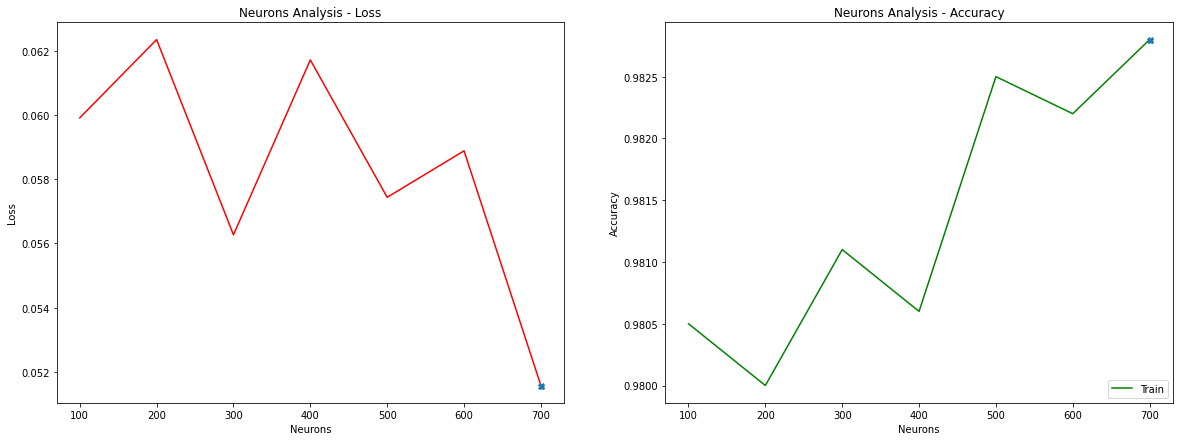

In [ ]:
resultsArray = np.array(modelsResults)

# best result: neurons = 700
print("Best result:", neurons[np.argmax(resultsArray, axis=0)[1]])

accuracyMaxIndex = np.argmax(resultsArray, axis=0)[1]
lossMinIndex = np.argmin(resultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('Neurons Analysis - Loss')
loss_ax.plot(neurons, resultsArray[:,0] , '-r', label='Train')
loss_ax.plot(neurons[lossMinIndex], resultsArray[:,0][lossMinIndex], "X")
loss_ax.set_xlabel("Neurons")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('Neurons Analysis - Accuracy')
acc_ax.plot(neurons, resultsArray[:,1], '-g', label='Train')
acc_ax.plot(neurons[accuracyMaxIndex], resultsArray[:,1][accuracyMaxIndex], "X")
acc_ax.set_xlabel("Neurons")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()

The next step is deciding the number of hidden layers of our model. The best results were achieved with 700 neurons per layer, so we'll explore between 1 and 6 hidden layers, each with 700 neurons.

In [ ]:
modelsResults = []
for i in range(1,7):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  mnist_conv_model = tf.keras.Sequential(name='mnist_cnn')
  mnist_conv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
  mnist_conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
  mnist_conv_model.add(tf.keras.layers.Flatten(name='flatten'))

  for j in range(1,i+1):
    mnist_conv_model.add(tf.keras.layers.Dense(700, activation='relu', name='hl'+str(j)))

  mnist_conv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_conv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_conv_model.summary()
  
  checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
  mnist_conv_model_train = mnist_conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_conv_model.load_weights('mnist_conv_best.h5')
  loss, acc = mnist_conv_model.evaluate(mnist_test_x, mnist_test_y)
  modelsResults += [[loss, acc]]
  print('Accuracy: {}'.format(acc))
  print('Loss: {}'.format(loss))

Let's now plot:

In [ ]:
#resultsArray = np.array(modelsResults)
resultsArray = np.array([[0.056138746440410614, 0.9811000227928162], [0.05270325392484665, 0.9837999939918518], [0.05080743879079819, 0.983299970626831], [0.05260307714343071, 0.9832000136375427], [0.05461176857352257, 0.9837999939918518], [0.05053083971142769, 0.984000027179718]])

# best result: layers = 6
layers = [1,2,3,4,5,6]
print("Best result:", layers[np.argmax(resultsArray, axis=0)[1]])
#print(resultsArray[:,1])

accuracyMaxIndex = np.argmax(resultsArray, axis=0)[1]
lossMinIndex = np.argmin(resultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('Number of Hidden Layers Analysis - Loss')
loss_ax.plot(layers, resultsArray[:,0] , '-r', label='Train')
loss_ax.plot(layers[lossMinIndex], resultsArray[:,0][lossMinIndex], "X")
loss_ax.set_xlabel("Number of Hidden Layers")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('Number of Hidden Layers Analysis - Accuracy')
acc_ax.plot(layers, resultsArray[:,1], '-g', label='Train')
acc_ax.plot(layers[accuracyMaxIndex], resultsArray[:,1][accuracyMaxIndex], "X")
acc_ax.set_xlabel("Number of Hidden Layers")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()

Let's now explore the usage of regularization. The network will have 6 hidden layers with 700 neurons each, the values previously found to deliever the best results.

We begin with L2 Regularization:

In [ ]:
L2modelRegularizationResults = []
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

for i in range(0,100, 10):
  mnist_conv_model_l2 = tf.keras.Sequential(name='mnist_cnn_l2'+str(i))
  mnist_conv_model_l2.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_conv_model_l2.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
  mnist_conv_model_l2.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
  mnist_conv_model_l2.add(tf.keras.layers.Flatten(name='flatten'))

  for j in range(1,7):
    mnist_conv_model_l2.add(tf.keras.layers.Dense(700, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i/100), name='hl_'+str(j)))
  
  mnist_conv_model_l2.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_conv_model_l2.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_conv_model_l2.summary()

  filename = 'mnist_conv_6hl'+str(i)+'best.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True)
  mnist_conv_model_l2_train = mnist_conv_model_l2.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_conv_model_l2.load_weights(filename)
  loss, acc = mnist_conv_model_l2.evaluate(mnist_test_x, mnist_test_y)
  L2modelRegularizationResults += [[loss, acc]]
  print(L2modelRegularizationResults)

for result in L2modelRegularizationResults:
  print(result)

In [ ]:
L2regularizationResultsArray = np.array(L2modelRegularizationResults)
regLimits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# best result: 0-0.1 
print("Best result:", regLimits[np.argmax(L2regularizationResultsArray, axis=0)[1]])

accuracyMaxIndex = np.argmax(L2regularizationResultsArray, axis=0)[1]
lossMinIndex = np.argmin(L2regularizationResultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('L2 Regularization Broad Analysis - Loss')
loss_ax.plot(regLimits, L2regularizationResultsArray[:,0] , '-r', label='Train')
loss_ax.plot(regLimits[lossMinIndex], L2regularizationResultsArray[:,0][lossMinIndex], "X")
loss_ax.set_xlabel("Regularization Factor")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('L2 Regularization Broad Analysis - Accuracy')
acc_ax.plot(regLimits, L2regularizationResultsArray[:,1], '-g', label='Train')
acc_ax.plot(regLimits[accuracyMaxIndex], L2regularizationResultsArray[:,1][accuracyMaxIndex], "X")
acc_ax.set_xlabel("Regularization Factor")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()

Let's now try the L1 Regularization:

In [ ]:
L1modelRegularizationResults = []
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

for i in range(0,100, 10):
  mnist_conv_model_l1 = tf.keras.Sequential(name='mnist_cnn_l1'+str(i))
  mnist_conv_model_l1.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_conv_model_l1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
  mnist_conv_model_l1.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
  mnist_conv_model_l1.add(tf.keras.layers.Flatten(name='flatten'))

  for j in range(1,7):
    mnist_conv_model_l1.add(tf.keras.layers.Dense(700, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(i/100), name='hl_'+str(j)))
  
  mnist_conv_model_l1.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_conv_model_l1.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_conv_model_l1.summary()

  filename = 'mnist_conv_6hl'+str(i)+'best.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True)
  mnist_conv_model_l1_train = mnist_conv_model_l1.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_conv_model_l1.load_weights(filename)
  loss, acc = mnist_conv_model_l1.evaluate(mnist_test_x, mnist_test_y)
  L1modelRegularizationResults += [[loss, acc]]
  print(L1modelRegularizationResults)

for result in L1modelRegularizationResults:
  print(result)

In [ ]:
L1regularizationResultsArray = np.array(L1modelRegularizationResults)
regLimits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# best result: 0-0.1 
print("Best result:", regLimits[np.argmax(L1regularizationResultsArray, axis=0)[1]])

accuracyMaxIndex = np.argmax(L1regularizationResultsArray, axis=0)[1]
lossMinIndex = np.argmin(L1regularizationResultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('L1 Regularization Broad Analysis - Loss')
loss_ax.plot(regLimits, L1regularizationResultsArray[:,0] , '-r', label='Train')
loss_ax.plot(regLimits[lossMinIndex], L1regularizationResultsArray[:,0][lossMinIndex], "X")
loss_ax.set_xlabel("Regularization Factor")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('L1 Regularization Broad Analysis - Accuracy')
acc_ax.plot(regLimits, L1regularizationResultsArray[:,1], '-g', label='Train')
acc_ax.plot(regLimits[accuracyMaxIndex], L1regularizationResultsArray[:,1][accuracyMaxIndex], "X")
acc_ax.set_xlabel("Regularization Factor")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()

Let's compare both regularizations:

In [ ]:
L1regularizationResultsArray = np.array(L1modelRegularizationResults)
L2regularizationResultsArray = np.array(L2modelRegularizationResults)

regLimits = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# best result: 0-0.1 
print("Best result:", regLimits[np.argmax(regularizationResultsArray, axis=0)[1]])

L1accuracyMaxIndex = np.argmax(L1regularizationResultsArray, axis=0)[1]
L1lossMinIndex = np.argmin(L1regularizationResultsArray, axis=0)[0]
L2accuracyMaxIndex = np.argmax(L2regularizationResultsArray, axis=0)[1]
L2lossMinIndex = np.argmin(L2regularizationResultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('Regularization Broad Analysis - Loss')
loss_ax.plot(regLimits, L1regularizationResultsArray[:,0] , '-g', label='L1')
loss_ax.plot(regLimits, L2regularizationResultsArray[:,0] , '-b', label='L2')
#loss_ax.plot(regLimits[lossMinIndex], L1regularizationResultsArray[:,0][L1lossMinIndex], "X")
#loss_ax.plot(regLimits[lossMinIndex], L2regularizationResultsArray[:,0][L2lossMinIndex], "X")

loss_ax.set_xlabel("Regularization Factor")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('Regularization Broad Analysis - Accuracy')
acc_ax.plot(regLimits, L1regularizationResultsArray[:,1] , '-g', label='L1')
acc_ax.plot(regLimits, L2regularizationResultsArray[:,1] , '-b', label='L2')
#acc_ax.plot(regLimits[L1accuracyMaxIndex], L1regularizationResultsArray[:,1][L1accuracyMaxIndex], "X")
#acc_ax.plot(regLimits[L2accuracyMaxIndex], L2regularizationResultsArray[:,1][L2accuracyMaxIndex], "X")
acc_ax.set_xlabel("Regularization Factor")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()

Now we shorten the intervals to find the ideal value:

In [ ]:
L1modelRegularizationResults = []
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

for i in range(0,100, 10):
  mnist_conv_model_l1 = tf.keras.Sequential(name='mnist_cnn_l1'+str(i))
  mnist_conv_model_l1.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_conv_model_l1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
  mnist_conv_model_l1.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
  mnist_conv_model_l1.add(tf.keras.layers.Flatten(name='flatten'))

  for j in range(1,7):
    mnist_conv_model_l1.add(tf.keras.layers.Dense(700, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(i/1000), name='hl_'+str(j)))
  
  mnist_conv_model_l1.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_conv_model_l1.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_conv_model_l1.summary()

  filename = 'mnist_conv_6hl'+str(i)+'best.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True)
  mnist_conv_model_l1_train = mnist_conv_model_l1.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_conv_model_l1.load_weights(filename)
  loss, acc = mnist_conv_model_l1.evaluate(mnist_test_x, mnist_test_y)
  L1modelRegularizationResults += [[loss, acc]]
  print(L1modelRegularizationResults)

for result in L1modelRegularizationResults:
  print(result)

In [ ]:
L2modelRegularizationResults = []
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

for i in range(0,100, 10):
  mnist_conv_model_l2 = tf.keras.Sequential(name='mnist_cnn_l2'+str(i))
  mnist_conv_model_l2.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_conv_model_l2.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
  mnist_conv_model_l2.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
  mnist_conv_model_l2.add(tf.keras.layers.Flatten(name='flatten'))

  for j in range(1,7):
    mnist_conv_model_l2.add(tf.keras.layers.Dense(700, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i/1000), name='hl_'+str(j)))
  
  mnist_conv_model_l2.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_conv_model_l2.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_conv_model_l2.summary()

  filename = 'mnist_conv_6hl'+str(i)+'best.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True)
  mnist_conv_model_l2_train = mnist_conv_model_l2.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_conv_model_l2.load_weights(filename)
  loss, acc = mnist_conv_model_l2.evaluate(mnist_test_x, mnist_test_y)
  L2modelRegularizationResults += [[loss, acc]]
  print(L2modelRegularizationResults)

for result in L2modelRegularizationResults:
  print(result)

In [ ]:
L1regularizationResultsArray = np.array(L1modelRegularizationResults)
L2regularizationResultsArray = np.array(L2modelRegularizationResults)
print(L1regularizationResultsArray)
print(L2regularizationResultsArray)

regLimits = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

L1accuracyMaxIndex = np.argmax(L1regularizationResultsArray, axis=0)[1]
L1lossMinIndex = np.argmin(L1regularizationResultsArray, axis=0)[0]
L2accuracyMaxIndex = np.argmax(L2regularizationResultsArray, axis=0)[1]
L2lossMinIndex = np.argmin(L2regularizationResultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('Regularization Broad Analysis - Loss')
loss_ax.plot(regLimits, L1regularizationResultsArray[:,0] , '-g', label='L1')
loss_ax.plot(regLimits, L2regularizationResultsArray[:,0] , '-b', label='L2')
#loss_ax.plot(regLimits[lossMinIndex], L1regularizationResultsArray[:,0][L1lossMinIndex], "X")
#loss_ax.plot(regLimits[lossMinIndex], L2regularizationResultsArray[:,0][L2lossMinIndex], "X")

loss_ax.set_xlabel("Regularization Factor")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('Regularization Broad Analysis - Accuracy')
acc_ax.plot(regLimits, L1regularizationResultsArray[:,1] , '-g', label='L1')
acc_ax.plot(regLimits, L2regularizationResultsArray[:,1] , '-b', label='L2')
#acc_ax.plot(regLimits[L1accuracyMaxIndex], L1regularizationResultsArray[:,1][L1accuracyMaxIndex], "X")
#acc_ax.plot(regLimits[L2accuracyMaxIndex], L2regularizationResultsArray[:,1][L2accuracyMaxIndex], "X")
acc_ax.set_xlabel("Regularization Factor")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()

DROPOUT

In [ ]:
dropoutModelRegularizationResults = []
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

for i in range(10):
  mnist_conv_drop_model = tf.keras.Sequential(name='mnist_cnn_dropout'+str(i/10))
  mnist_conv_drop_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  mnist_conv_drop_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
  mnist_conv_drop_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
  mnist_conv_drop_model.add(tf.keras.layers.Dropout(i/10, name='dropout0'))
  mnist_conv_drop_model.add(tf.keras.layers.Flatten(name='flatten'))

  for j in range(6):
    mnist_conv_drop_model.add(tf.keras.layers.Dense(700, activation='relu', name='hl_'+str(j)))
  
  mnist_conv_drop_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  mnist_conv_drop_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  mnist_conv_drop_model.summary()

  filename = 'mnist_conv_dropout_'+str(i/10)+'best.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_accuracy', verbose=1, save_best_only=True)
  mnist_conv_drop_model_train = mnist_conv_drop_model.fit(mnist_train_x[:5000], mnist_train_y[:5000], validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

  mnist_conv_drop_model.load_weights(filename)
  loss, acc = mnist_conv_drop_model.evaluate(mnist_test_x, mnist_test_y)
  dropoutModelRegularizationResults += [[loss, acc]]
  print(dropoutModelRegularizationResults)

for result in dropoutModelRegularizationResults:
  print(result)

In [ ]:
#L1regularizationResultsArray = np.array(modelRegularizationResultsL1)
dropoutResultsArray = np.array(dropoutModelRegularizationResults)

regLimits = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
print("Best result:", regLimits[np.argmax(dropoutResultsArray, axis=0)[1]])

#L1accuracyMaxIndex = np.argmax(L1regularizationResultsArray, axis=0)[1]
#L1lossMinIndex = np.argmin(L1regularizationResultsArray, axis=0)[0]
accuracyMaxIndex = np.argmax(dropoutResultsArray, axis=0)[1]
lossMinIndex = np.argmin(dropoutResultsArray, axis=0)[0]

fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))
loss_ax.set_title('Dropout Analysis - Loss')
#loss_ax.plot(regLimits, L1regularizationResultsArray[:,0] , '-g', label='L1')
loss_ax.plot(regLimits, dropoutResultsArray[:,0] , '-b', label='L2')
#loss_ax.plot(regLimits[lossMinIndex], L1regularizationResultsArray[:,0][L1lossMinIndex], "X")
#loss_ax.plot(regLimits[lossMinIndex], L2regularizationResultsArray[:,0][L2lossMinIndex], "X")

loss_ax.set_xlabel("Dropout Factor")
loss_ax.set_ylabel("Loss")

acc_ax.set_title('Regularization Detail Analysis - Accuracy')
#acc_ax.plot(regLimits, L1regularizationResultsArray[:,1] , '-g', label='L1')
acc_ax.plot(regLimits, dropoutResultsArray[:,1] , '-b', label='L2')
#acc_ax.plot(regLimits[L1accuracyMaxIndex], L1regularizationResultsArray[:,1][L1accuracyMaxIndex], "X")
#acc_ax.plot(regLimits[L2accuracyMaxIndex], L2regularizationResultsArray[:,1][L2accuracyMaxIndex], "X")
acc_ax.set_xlabel("Dropout Factor")
acc_ax.set_ylabel("Accuracy")

plt.legend(loc=4)
plt.show()